# Szyfry blokowe
Szyfry blokowe są obecnie najczęście używaną grupą szyfrów. Najważniejszą ich cechą charakterystyczną jest działanie na blokach pamięci (o rozmiarze 64 lub 128 bitów). Szyfr blokowy przekształca blok tekstu jawnego do bloku szyfrogramu. Idealnie gdy każdy bit bloku szyfrogramu zależy od wszystkich bitów odpowiedniego bloku tekstu jawnego. 

Blokowość szyfrowania sprawia, że konieczne jest określenie w jaki sposób kolejne bloku wiadomości są szyfrowane.  Schematy postępowania w tym przypadku określane są mianem ** trybów algorytmów szyfrowych**: ECB, CBC, CFB, OFB, CTR, GCM. Najprotszy tryb ECB zakłada, że każdy blok szyfrowany jest tym samym kluczem niezależnie od innych. Z oczywistych względów takie rozwiązanie jest niezalecane. Pozostałe tryby oferują bezpieczniejszy schemat przetwarzania ciągu bloków. 

Kolejnym problemem jaki musi rozwiązać implementator szyfru blokowego jest uwzględnienie sytuacji gdy rozmiar wiadomości jawnej nie jest równy wielokrotności rozmiary bloków. W takiej sytuacji konieczna jest implementacja ** dopełnienia** ostatniego niepełnego bloku. 



## Szyfr DES (Data Encryption Standard)

https://www.schneier.com/blog/archives/2004/10/the_legacy_of_d.html

DES (Data Encryption Standard) został opracowany w laboratoriach IBM pod nazwą Lucifer na poczatku lat 70tych XX wieku. W 1975 szyfr ten po pewnych modyfikacjach zostało przyjęty jako standard szyfrowania DES.

Szyfr DES ma konstrukcję opartą o sieć Feistela. Podobna konstrukcja wykorzystywana jest w wielu innych szyfrach, np. Blowfish, Twofish, CAST-128 (Wikipedia wymiania ok. 15 algorytmów)

Algorytm DES wykorzystuje S-boxy oraz tzw. przekształcenie Feistela. Operacje te powtarzane są 16 razy. Przed rozpocząciem szyfrowania klucz główny przekształcany jest do 16 podkluczy dla każdej z rund. 

DES został poddany bardzo wnikliwym atakom. Opracowano dla niego skuteczne metody kryptoanalizy: różnicowa i liniowa. W głównej mierze jednak największą słabością okazała się  długość klucza. 

Żywot DES był przedłużany przez liczne modyfikacje, z których najbardziej znaną jest 3DES, używający trzech kluczy i sekwencji szyfrowanie+deszyfrowanie+szyfrowanie. 

### Zarządzenie kluczem (key scheduling) w DES
##### 1. Redukcja klucza 64-> 56 bitów i wstępna permutacja
> Key size was reduced to 56 bits because IBM wanted to fit LUCIFER on a single chip. (Stallings, W. Cryptography and network security, 5th ed.. p.78)

> The NSA made two changes to DES: It tweaked the algorithm, and it cut the key size by more than half. (Schneier)

> But whereas Lucifer had a key that was 112 bits long, the DES key was shortened to 56 bits at the request of the National Security Agency. (http://www.diablotin.com/librairie/networking/puis/ch06_04.htm) 

64 bitowy klucz szyfrowania jest wstępnie permutowany, a niektóre bity są pomijane. 

In [20]:
#Schemat permutacji z kompresją 
PC1 = [57,49,41,33,25,17,9,1,58,50,42,34,26,18,10,2,59,51,43,35,27,19,11,3,60,52,44,36,63,55,47,39,31,23,15,7,62,54,46,38,30,22,14,6,61,53,45,37,29,21,13,5,28,20,12,4]

def apply_PC1(pc1_table,keys_64bits):
    keys_56bits = ""
    for index in pc1_table:
        keys_56bits += keys_64bits[index-1] 
    return keys_56bits

# Test
keys_64bits = "0001001100110100010101110111100110011011101111001101111111110001"
keys_56bits = apply_PC1(PC1,keys_64bits)
#Poprawne wyjście: 11110000110011001010101011110101010101100110011110001111
print('Klucz DES zredukowany do 56 bitów:', keys_56bits)

Klucz DES zredukowany do 56 bitów: 11110000110011001010101011110101010101100110011110001111


#####  2. Podział klucza na dwie 28-bitowe części 

In [21]:
def split56bits_in_half(keys_56bits):
    left_keys, right_keys = keys_56bits[:28],keys_56bits[28:]
    return left_keys, right_keys

left56 , right56 = split56bits_in_half(keys_56bits)

print('Lewa strona:  ', left56)
print('Prawa strona: ',right56)

Lewa strona:   1111000011001100101010101111
Prawa strona:  0101010101100110011110001111


##### 3. Rotacja klucza o 1 lub 2 bity
Rotacja o 1 bit następuje tylko w rundach 1, 2, 9, 16. W pozostałych rundach rotujemy od dwa. 

In [22]:
def circular_left_shift(bits,numberofbits):
     shiftedbits = bits[numberofbits:] + bits[:numberofbits]
     return shiftedbits

print("Lewa połowa klucza po przesunięciu:  ",circular_left_shift(left56,1))
print("Prawa połowa klucza po przesunięciu: ",circular_left_shift(right56,2))

Lewa połowa klucza po przesunięciu:   1110000110011001010101011111
Prawa połowa klucza po przesunięciu:  0101010110011001111000111101


##### 4. Permutacja z kompresją 2 x 28 bit > 48 bit

In [23]:
PC2 = [14,17,11,24,1,5,3,28,15,6,21,10,23,19,12,4,26,8,16,7,27,20,13,2, 41,52,31,37,47,55,30,40,51,45,33,48,44,49,39,56,34,53,46,42,50,36,29,32]
def apply_PC2(pc2_table,keys_56bits):
    keys_48bits = ""
    for index in pc2_table:
        keys_48bits += keys_56bits[index-1]
    return keys_48bits

# Test 
left_half = "1111000011001100101010101111"
right_half = "0101010101100110011110001111"

subkey = apply_PC2(PC2,left_half + right_half)

print("Przykładowy klucz podrundy: ", subkey)

Przykładowy klucz podrundy:  110010110011110110001011000011100001011111110101


#### Generowanie 48-bitowych podkluczy rund 
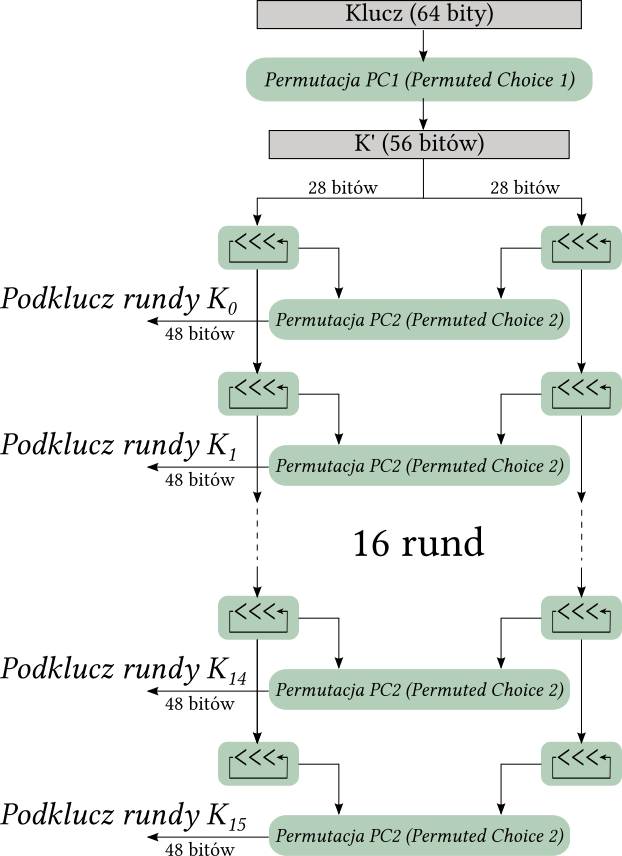
Poskładajmy wszystko w całość: 

In [24]:
round_shifts = [1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1]

def generate_keys(key_64bits):
    round_keys = list() 
    reduced_key = apply_PC1(PC1, key_64bits)	
    left_side, right_side = split56bits_in_half(reduced_key)
    for i in range(16):
        left_side = circular_left_shift(left_side, round_shifts[i])
        right_side = circular_left_shift(right_side, round_shifts[i])

        subkey = apply_PC2(PC2, left_side + right_side)
        round_keys.append(subkey)
    return round_keys

#test 
key_64bits = "0001001100110100010101110111100110011011101111001101111111110001"

subkeys = generate_keys(key_64bits)

print("Lista 16 podkluczy: ")
print("\n".join(subkeys))

Lista 16 podkluczy: 
000110110000001011101111111111000111000001110010
011110011010111011011001110110111100100111100101
010101011111110010001010010000101100111110011001
011100101010110111010110110110110011010100011101
011111001110110000000111111010110101001110101000
011000111010010100111110010100000111101100101111
111011001000010010110111111101100001100010111100
111101111000101000111010110000010011101111111011
111000001101101111101011111011011110011110000001
101100011111001101000111101110100100011001001111
001000010101111111010011110111101101001110000110
011101010111000111110101100101000110011111101001
100101111100010111010001111110101011101001000001
010111110100001110110111111100101110011100111010
101111111001000110001101001111010011111100001010
110010110011110110001011000011100001011111110101


##### Zastanów się 
1. Sprawdź jak wyglądają klucze rundy wygenerowane dla poniższych kluczy głównych
2. Poszukaj informacji o kluczach słabych i półsłabych
3. Podaj inne przykłady kluczy słabych dla DES

In [25]:
strangekey1 = '1111111011111110111111101111111011111110111111101111111011111110'
strangekey2 = '1110000011100000111000001110000011110001111100011111000111110001'

subkeys_strange_1 = generate_keys(strangekey1)
subkeys_strange_2 = generate_keys(strangekey2)


print("Lista 16 podkluczy: ")
print("\n".join(subkeys_strange_1))
print("\n".join(subkeys_strange_2))



Lista 16 podkluczy: 
111111111111111111111111111111111111111111111111
111111111111111111111111111111111111111111111111
111111111111111111111111111111111111111111111111
111111111111111111111111111111111111111111111111
111111111111111111111111111111111111111111111111
111111111111111111111111111111111111111111111111
111111111111111111111111111111111111111111111111
111111111111111111111111111111111111111111111111
111111111111111111111111111111111111111111111111
111111111111111111111111111111111111111111111111
111111111111111111111111111111111111111111111111
111111111111111111111111111111111111111111111111
111111111111111111111111111111111111111111111111
111111111111111111111111111111111111111111111111
111111111111111111111111111111111111111111111111
111111111111111111111111111111111111111111111111
111111111111111111111111000000000000000000000000
111111111111111111111111000000000000000000000000
111111111111111111111111000000000000000000000000
111111111111111111111111000000000000000000000000

### Nieliniowa funkcja rundy F()
Nieliniowa funkcja F() używana jest wielokrotnie w trakcie szyfrowania w celu przekształcenia połowy bloku i połączeniu go z kluczem odpowiedniej rundy. Składnikami tej funkcji są następujące operacje:

##### 1. 32-bitowy blok wiadomości jest rozszerzany do długości 48-bitów. 
Sposób rozszerzenia określa permutacja z powieleniem niektórych bitów. Dokładnie 16 z 32 bitów wejściowych muszą się powtórzyć w bloku wyjściowym. Rozszerzenie jest zaplanowane w taki sposób, aby nigdy ten sam bit nie trafił do tej samej 6-bitowej porcji. Celem rozszerzenia jest zwiększenie dyfuzji bitów - niektóre bity oddziałują na wynik dwukrotnie.   

In [26]:
EXPANSION_TABLE = [32,1,2,3,4,5,4,5,6,7,8,9,8,9,10,11,12,13,12,13,14,15,16,17,
16,17,18,19,20,21,20,21,22,23,24,25,24,25,26,27,28,29,28,29,30,31,32,1]

def apply_Expansion(expansion_table,bits32):
    """ Rozszerza 32-bitowy blok do 48 bitów, używając zadanego schematu"""
    bits48 = ""
    for index in expansion_table:
        bits48 += bits32[index-1]
    return bits48

#test 
bits32 = '11110000101010101111000010101010'
out_bits48 = apply_Expansion(EXPANSION_TABLE,bits32)
print("Rozszerzony blok wiadomości: ", out_bits48)
# 011110100001010101010101011110100001010101010101


Rozszerzony blok wiadomości:  011110100001010101010101011110100001010101010101


XOR dwóch bloków (zawsze się przydaje)

In [27]:
def XOR(bits1,bits2):
    # ciągi muszą być równej długości
    xor_result = ""
    for index in range(len(bits1)):
        if bits1[index] == bits2[index]: 
            xor_result += '0'
        else:
            xor_result += '1'
    return xor_result

bits1 = '1100'
bits2 = '1010'
print(XOR(bits1,bits2))
# output: '0110'

0110


##### 2. Aplikacja Sboksów (S-Box).
Sboksy są rdzeniem przekształcenia realizowanego przez funkcję rundy F. **Ich zadaniem jest wprowadzenie nieliniowości do przekształcenia bloku bitów**. W przypadku DES taka a nie inna postać Sboksów wynikała z chęci zabezpieczenia szyfru przed kryptoanalizą różnicową, która w latach 70' nie była znana ,,cywilnym'' kryptografom. Jednym z celów przyświecających projektantom było uzyskanie **efektu lawinowego** (strict avalanche effect) to znaczy zmiana 1 bitu wejściowego powinna wywołać zmianę wszystkich bitów wyjściowych z 50% prawdopodobieństwem. Projektanci zdefiniowali także inne kryteria, które miały spełniać ciągi bitó wejściowych i wyjściowych a następnie wyszukali sboksy, które spełniały te kryteria (D. Coppersmith,  The Data Encryption Standard (DES) and its strength against attacks).

In [28]:
SBOX = [
# Box-1
[
[14,4,13,1,2,15,11,8,3,10,6,12,5,9,0,7],
[0,15,7,4,14,2,13,1,10,6,12,11,9,5,3,8],
[4,1,14,8,13,6,2,11,15,12,9,7,3,10,5,0],
[15,12,8,2,4,9,1,7,5,11,3,14,10,0,6,13]
],
# Box-2

[
[15,1,8,14,6,11,3,4,9,7,2,13,12,0,5,10],
[3,13,4,7,15,2,8,14,12,0,1,10,6,9,11,5],
[0,14,7,11,10,4,13,1,5,8,12,6,9,3,2,15],
[13,8,10,1,3,15,4,2,11,6,7,12,0,5,14,9]
],

# Box-3

[
[10,0,9,14,6,3,15,5,1,13,12,7,11,4,2,8],
[13,7,0,9,3,4,6,10,2,8,5,14,12,11,15,1],
[13,6,4,9,8,15,3,0,11,1,2,12,5,10,14,7],
[1,10,13,0,6,9,8,7,4,15,14,3,11,5,2,12]

],

# Box-4
[
[7,13,14,3,0,6,9,10,1,2,8,5,11,12,4,15],
[13,8,11,5,6,15,0,3,4,7,2,12,1,10,14,9],
[10,6,9,0,12,11,7,13,15,1,3,14,5,2,8,4],
[3,15,0,6,10,1,13,8,9,4,5,11,12,7,2,14]
],

# Box-5
[
[2,12,4,1,7,10,11,6,8,5,3,15,13,0,14,9],
[14,11,2,12,4,7,13,1,5,0,15,10,3,9,8,6],
[4,2,1,11,10,13,7,8,15,9,12,5,6,3,0,14],
[11,8,12,7,1,14,2,13,6,15,0,9,10,4,5,3]
],
# Box-6

[
[12,1,10,15,9,2,6,8,0,13,3,4,14,7,5,11],
[10,15,4,2,7,12,9,5,6,1,13,14,0,11,3,8],
[9,14,15,5,2,8,12,3,7,0,4,10,1,13,11,6],
[4,3,2,12,9,5,15,10,11,14,1,7,6,0,8,13]

],
# Box-7
[
[4,11,2,14,15,0,8,13,3,12,9,7,5,10,6,1],
[13,0,11,7,4,9,1,10,14,3,5,12,2,15,8,6],
[1,4,11,13,12,3,7,14,10,15,6,8,0,5,9,2],
[6,11,13,8,1,4,10,7,9,5,0,15,14,2,3,12]
],
# Box-8

[
[13,2,8,4,6,15,11,1,10,9,3,14,5,0,12,7],
[1,15,13,8,10,3,7,4,12,5,6,11,0,14,9,2],
[7,11,4,1,9,12,14,2,0,6,10,13,15,3,5,8],
[2,1,14,7,4,10,8,13,15,12,9,0,3,5,6,11]
]

]

Generalnie S-boksów używamy w taki sposób, że **kilkubitowe porcje bloku wejściowego używane są jako indeksu wskazującego odpowiednie wartości w S-boksie. Wskazane wartości zwracane są jako wyjściowe porcje bitów**. W przypadku DES S-boksy mają postać tablic prostokątnych o rozmiarach 4 x 16. Jako wejście S-boksy pobieramy 6-bitowe fragmenty i pierwszy oraz ostatni bit tej porcji złożone razem dają indeks wiersza tablicy S-boks. Kolumna tablicy wskazywana jest przez 4 środkowe bity. Zwracana porcja ma rozmiar 4 bitów. 

In [29]:
#znowu trochę funkcji pomoczniczych do działań na Sboxach.
import textwrap

#podział wiadomości na 6-bitowe porcje 48/6 = 8 
def split48bits_in_6bits(XOR_48bits):
    """Podział bloku 48-bitowego na 6-bitowe porcje """
    list_of_6bits = textwrap.wrap(XOR_48bits,6)
    return list_of_6bits

def get_first_and_last_bit(bits6):
    """Pobierz pierwszy i ostatni bit z 6-bitowego łańcucha bitów"""
    twobits = bits6[0] + bits6[-1] 
    return twobits

def get_middle_four_bit(bits6):
    """Pobierz środkowe 4 bity z z 6-bitowego łańcucha bitów"""
    fourbits = bits6[1:5] 
    return fourbits

def binary_to_decimal(binarybits):
    """ Konwersja łańcucha bitów do wartości dzięsiętnej """
    decimal = int(binarybits,2)
    return decimal

def decimal_to_binary(decimal):
    """ Konwersja wartości dziesiętnej do 4-bitowego łańcucha bitów """
    binary4bits = bin(decimal)[2:].zfill(4)
    return binary4bits

def sbox_lookup(sboxcount,first_last,middle4):
    """ Dostęp do odpowiedniej wartości odpowiedniego sboxa""" 
    d_first_last = binary_to_decimal(first_last)
    d_middle = binary_to_decimal(middle4)
    sbox_value = SBOX[sboxcount][d_first_last][d_middle]
    return decimal_to_binary(sbox_value)

#Test
bits48 = '011110100001010101010101011110100001010101010101'
sixbitslist = split48bits_in_6bits(bits48) 
print("Blok podzielony na 6-bitowe porcje:", sixbitslist)
bits6 = sixbitslist[0]
first_last = get_first_and_last_bit(bits6)  # '10' -> 2
print("Liczba z pierwszego i ostatniego bitu: ", first_last)
middle4 = get_middle_four_bit(bits6)  # '0000' -> 0
print("Liczba z środkowych 4 bitów:", middle4)

sboxcount = 0
result = sbox_lookup(sboxcount,first_last,middle4) 
print("4-bitowa wartość z s-box", result)

Blok podzielony na 6-bitowe porcje: ['011110', '100001', '010101', '010101', '011110', '100001', '010101', '010101']
Liczba z pierwszego i ostatniego bitu:  00
Liczba z środkowych 4 bitów: 1111
4-bitowa wartość z s-box 0111


##### 3. Wynik działania S-boxów jest podlega jeszcze finalnej permutacji.

In [30]:
PERMUTATION_TABLE = [16,7,20,21,29,12,28,17,1,15,23,26,5,18,31,10,
                     2,8,24,14,32,27,3,9,19,13,30,6,22,11,4,25]

def apply_Permutation(permutation_table,sboxes_output):
    """ Scalony efekt użycia Sboksów poddawany jest zdefiniowanej permutacji"""
    permuted32bits = ""
    for index in permutation_table:
        permuted32bits += sboxes_output[index-1]
    return permuted32bits

#####  5. Jak ma wyglądać nieliniowa funkcja rundy F()?  
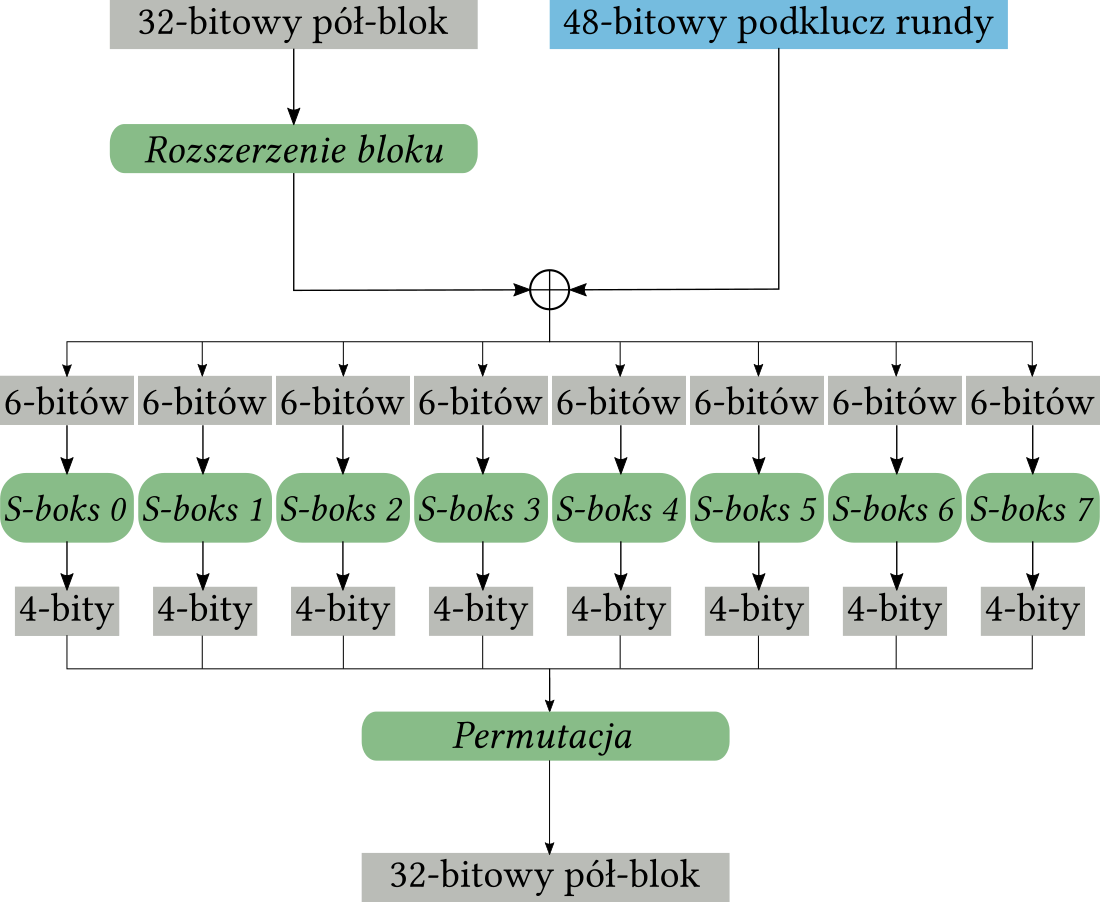

In [31]:
def functionF(pre32bits, key48bits):
    #uzupełnij kod funkcji zgodnie z diagramem powyżej 
    final32bits = ''
    # expanded to 48 bits
    extended_to_48bits = apply_Expansion(EXPANSION_TABLE, pre32bits)

    # xor
    xor_key = XOR(extended_to_48bits, key48bits)

    # into 6-bit blocks
    list_6_bits = split48bits_in_6bits(xor_key)

    # S-blocks
    i = 0
    for block in list_6_bits:
        two_bits = get_first_and_last_bit(block)
        middle_bits = get_middle_four_bit(block)
        res = sbox_lookup(i, two_bits, middle_bits)
        final32bits += res
        i += 1

    final32bits = apply_Permutation(PERMUTATION_TABLE, final32bits)

    return final32bits

#test 
bits32 = '11110000101010101111000010101010'
key48bits = '110010110011110110001011000011100001011111110101'
print("Wynik aplikowania F(): ", functionF(bits32, key48bits))

Wynik aplikowania F():  11010001010000100101101101111100


### Szyfrowanie DES
##### 1. Jak szyfruje DES? 
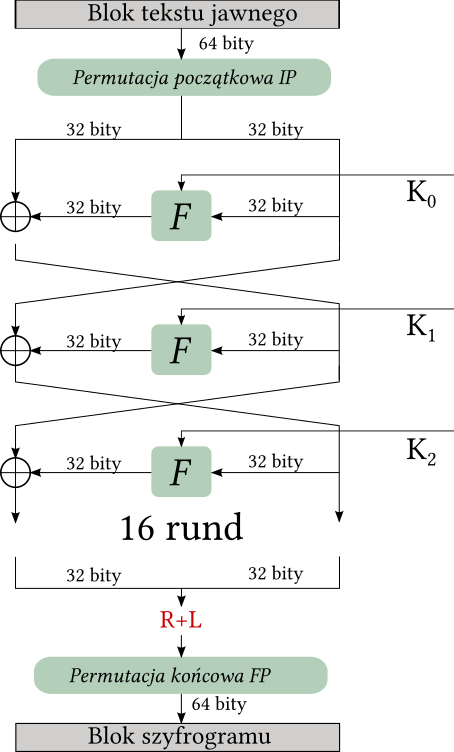

#### 2. Początkowa permutacja 
Początkowa i końcowa permutacja nie wpływają na bezpieczeństwo szyfru. W zasadzie mogą być bez szkody pominięte, ale wówczas szyfr nie będzie można nazywać DES. Podejrzewa się, że miały one na celu takie ułożenie bitów, aby implementacje sprzętowe lepiej wykorzystywały 8-bitowe magistrale używane w latach 70'. 

In [32]:
INITIAL_PERMUTATION_TABLE = ['58 ', '50 ', '42 ', '34 ', '26 ', '18 ', '10 ', '2',
            '60 ', '52 ', '44 ', '36 ', '28 ', '20 ', '12 ', '4',
            '62 ', '54 ', '46 ', '38 ', '30 ', '22 ', '14 ', '6', 
            '64 ', '56 ', '48 ', '40 ', '32 ', '24 ', '16 ', '8', 
            '57 ', '49 ', '41 ', '33 ', '25 ', '17 ', '9 ', '1',
            '59 ', '51 ', '43 ', '35 ', '27 ', '19 ', '11 ', '3',
            '61 ', '53 ', '45 ', '37 ', '29 ', '21 ', '13 ', '5',
            '63 ', '55 ', '47 ', '39 ', '31 ', '23 ', '15 ', '7']

def apply_permutation(P_TABLE, PLAINTEXT):
    permutated_M = ""
    for index in P_TABLE:
        permutated_M += PLAINTEXT[int(index)-1]
    return permutated_M

#Test
block = "0100000101110100011101000110000101100011011010110010000100100001" 
print("Binarna postać tekstu jawnego: ", block)
permuted_block = apply_permutation(INITIAL_PERMUTATION_TABLE,block)
print("Blok po początkowej permutacji:",permuted_block)

Binarna postać tekstu jawnego:  0100000101110100011101000110000101100011011010110010000100100001
Blok po początkowej permutacji: 0011111100000110000001101111100100000000111111100010000000110000


##### 3. Podział bloku 64-bitowego na dwie części 

In [33]:
def split64bits_in_half(binarybits):
    return binarybits[:32],binarybits[32:]

L0,R0 = split64bits_in_half(permuted_block)
print("Blok po podziale: ",L0,R0)

Blok po podziale:  00111111000001100000011011111001 00000000111111100010000000110000


##### 4. Finalna permutacja 

In [34]:
INVERSE_PERMUTATION_TABLE = ['40 ', '8 ', '48 ', '16 ', '56 ', '24 ', '64 ', '32',
                 '39 ', '7 ', '47 ', '15 ', '55 ', '23 ', '63 ', '31',
                 '38 ', '6 ', '46 ', '14 ',  '54 ', '22 ', '62 ', '30',
                 '37 ', '5 ', '45 ', '13 ', '53 ', '21 ', '61 ', '29',
                 '36 ', '4 ', '44 ', '12 ', '52 ', '20 ', '60 ', '28',
                 '35 ', '3 ', '43 ', '11 ', '51 ', '19 ', '59 ', '27', 
                 '34 ', '2 ', '42 ', '10 ', '50 ', '18 ', '58 ', '26',
                 '33 ', '1 ', '41 ', '9 ', '49 ', '17 ', '57 ', '25']


cipher = apply_permutation(INVERSE_PERMUTATION_TABLE, L0+R0)
print("Blok po finalnej permutacji:", cipher)

Blok po finalnej permutacji: 0100000101110100011101000110000101100011011010110010000100100001


##### 5. Przekształcenie Feistela 

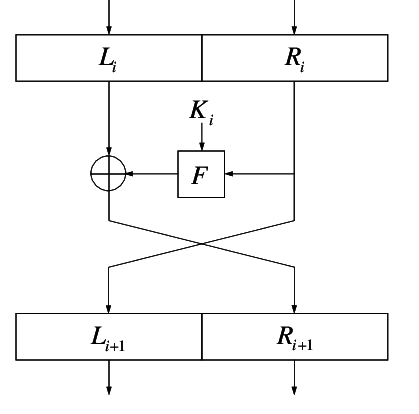

### Zastanów się 
1. Przenalizuj działanie sieci Feistela (do przodu i wstecz)
2. Dlaczego sieć Feistela jest popularnym rozwiązaniem w wielu szyfrach blokowych 

In [39]:
# 1. wygenerujmy klucze rundy 
key_64bits = "0001001100110100010101110111100110011011101111001101111111110001"
roundkeys = generate_keys(key_64bits)
# Testowa wartości bloków  
R = '11001100000000001100110011111111'  
L = '11110000101010101111000010101010'

print("Blok wejściowy", L+R)
# Sieć Feistela - uzupełnij kod wg schematu powyżej, użyj podklucza z dowolnej rundy 
R_i_1 = XOR(functionF(R, key48bits), L)
L_i_1 = R
print("Blok wyjściowy (szyfrogram)", L_i_1 + R_i_1)
# Wykonaj operacje odwrotne w sieci Feistela - sprawdź czy szyfrowanie się odwróci
L = XOR(functionF(L_i_1, key48bits), R_i_1)
R = L_i_1

print("Blok wyjściowy (tekst jawny)", L+R)

Blok wejściowy 1111000010101010111100001010101011001100000000001100110011111111
Blok wyjściowy (szyfrogram) 1100110000000000110011001111111110111000111100011000101110011010
Blok wyjściowy (tekst jawny) 1111000010101010111100001010101011001100000000001100110011111111


##### 6. Poskładajmy wszystko razem
Jeszcze raz cały DES: 
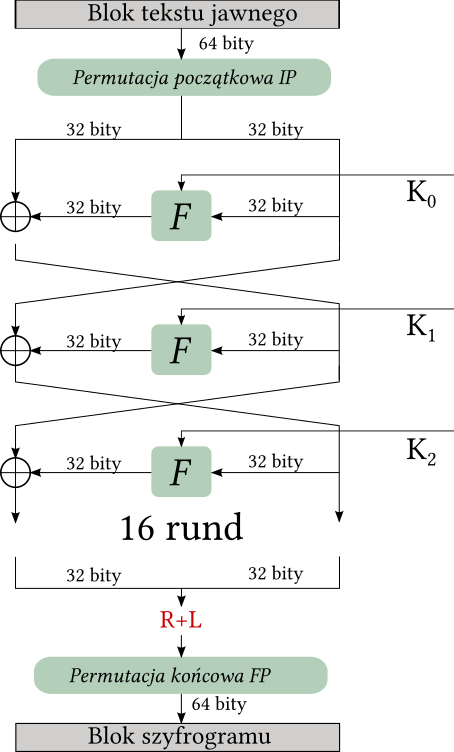

In [40]:
#Funkcje pomocnicze
get_bin = lambda x, n: format(x, 'b').zfill(n)

#tablica znaków w tablicę kodów int
def intoIntArray(message: str):
    int_array = []
    mesg_array = list(message) 
    for i in mesg_array:
        int_array.append(ord(i))
    return int_array

#tablica kodów int w tablice znaków 
def intoCharArray(message: list):
    mesg_char = []
    for i in message:
        mesg_char.append(chr(i))
    return mesg_char

def intListToBinStr(message_list):
    binary = []
    for x in message_list: 
        binary.append(get_bin(x, 8))
    binary_str = ""
    for x in binary:
        binary_str+=x 
    return binary_str

In [44]:
M = "Attack!!"
key = "EagleHasLanded" 

plaintext = intListToBinStr(intoIntArray(M)) 
print("Plaintext (64 bits):", plaintext)
binary_key = intListToBinStr(intoIntArray(key)) 
print("Key (only 64 bits): ", binary_key[:64])


def DES_encrypt(message,key):
    cipher = ""
    permuted_message = apply_Permutation(INITIAL_PERMUTATION_TABLE, message)
    L, R = split64bits_in_half(permuted_message)
    L0, R0 = L, R
    for _ in range(16):
        R, L = XOR(functionF(R, key48bits), L), R
        
    cipher = R + L
    cipher = apply_Permutation(INVERSE_PERMUTATION_TABLE, L0 + R0)

    return cipher
    
def DES_decrypt(message,key):
    cipher = ""
   
    return cipher    
    

ciphertext = DES_encrypt(plaintext, binary_key[:64])
print("Ciphertext:         ", ciphertext)
decrypted = DES_decrypt(ciphertext, binary_key[:64])
print("Encrypted message:  ", decrypted)
print(XOR(plaintext, decrypted))

Plaintext (64 bits): 0100000101110100011101000110000101100011011010110010000100100001
Key (only 64 bits):  0100010101100001011001110110110001100101010010000110000101110011
